# 混合分布モデルの応用

### テーマ

## 「イベント発生までの時間データを用いたセグメンテーション」

　指数分布の混合モデルを用いてデータのセグメンテーションを行う、教師なし学習アルゴリズムを実装しました。セグメントごとのイベント発生頻度を推定できます。また、新しいデータの分類も行うことができます。

### 実装に至った背景

　私は、複数の企業でデータアナリストとして長期インターンシップを経験しました。
そのなかで、イベント発生までの時間に関するデータを扱うことが多くありました。
具体的に扱った事例としては、webサイト登録者が解約するまでの時間データや、顧客の再来店までの時間データです。
インターンに参加していたときは、これらのデータの集計や、統計的な要因分析とモデルの構築を行いました。

　しかしインターン終了後に私は、これらのデータから「イベントの発生頻度ごと」に、グループ分けを行う教師なし学習アルゴリズムを作りたいと考えました。
理由は、観測された時間データから速やかに意思決定を行うことができるからです。
例えば、あるイベントについて、高頻度でイベントを発生するユーザーと、低頻度のユーザーでは思考に違いがあると予想されます。セグメンテーションを行うことで、処方的な対策へと繋げることができます。

　インターン参加期間中には、アルゴリズムの実装は行えず発展的な分析は行えませんでした。しかし今後、似た分析を行ったときに今回のモデルを用いてビジネス上の意思決定に繋げていきたいです。

### アプローチ1

　色々なデータ分析を経験したなかで、イベント発生までの時間は、右肩下がりの分布になっていることが多かったです。
このことから、一般的なイベントはポアソン過程に従っているのではないかと考えました。
そしてポアソン過程に従うイベントの発生までの観測時間は指数分布に従うことを用いました。

### アプローチ2

　次に、指数分布の観測データからセグメンテーションを行うアルゴリズムを考えました。
ここでは混合モデルによる推定を用いました。推定方法については、計算の速い最尤法で、EMアルゴリズムを使いました。

<br>

<br>

## アルゴリズムの導出

データ$x_i, i = 1, \cdots, N$が与えられているとし、$x_i$ はイベント発生までにかかる時間とします。

ポアソン過程に従うイベントの場合、この時間$x_i$は指数分布に従います。

パラメーター $\lambda$ を持つ指数分布の確率密度関数(pdf)は、次のように定義されます。

$$
f(x_i) = \lambda exp(-\lambda x_i)
$$

次に指数分布の混合モデルを考えます。

$\lambda = (\lambda_1,\lambda_2,\cdots,\lambda_K)$ , $\lambda_k > 0$,<br>
$\pi = (\pi_1,\pi_2,\cdots,\pi_K)$ , $0<\pi_k<1$ , $\sum_{k = 1}^{K}\pi_k = 1 $を満たすとします。

$\pi_k$は、混合確率を表し、K個の指数分布を混合します。

混合指数分布のpdfは、

$$
f(x_i|\pi,\lambda) = \sum_{k = 1}^{K}\pi_k \lambda_k exp(-\lambda_k x_i)
$$

となります。

次に、N個のデータから、最尤推定を行います。最適化問題は対数尤度関数を用いて、

$$
\max_{\lambda,\pi} 
    \left[
        \sum_{i=1}^{N}
            \log{\sum_{k = 1}^{K}\pi_k \lambda_k exp(-\lambda_k x_i)}
    \right]　\\ \\
s.t. \sum_{k = 1}^{K}\pi_{k} = 1
$$

このままでは、解析的に解くのが難しいため、
対数尤度関数の下界を最大化する式に変形すると、

$$
\max_{Q}
    \left[
        \sum_{i = 1}^{N}\sum_{k = 1}^{K}Q_{ik}(\log{\pi_k} + 
        \log{\lambda_k} -\lambda_k x -\log{Q_{ik}})
    \right]\\ \\
s.t. \sum_{k = 1}^{K}Q_{ik} = 1 , i = 1,\cdots, N
$$

上記の最適化問題をラグランジュ未定乗数法で$Q_{ik}$について解き、

$$
Q_{ik} = \frac{\pi_k\lambda_k\exp(-\lambda_k x_i)}
{\sum_{k'= 1}^{K}\pi_{k'}\lambda_{k'}\exp(-\lambda_{k'}x_i)}
$$

この$Q_{ik}$を使って、関数を最大化する$\lambda_k,\pi_k$について解くと、

$$
\begin{align}
\lambda_k &= \frac{\sum_{i = 1}^{N}Q_{ik}}{\sum_{i' = 
1}^{N}Q_{i'k}x_{i'}} \\
\pi_k &= \frac{\sum_{i = 1}^{N}Q_{ik}}{\sum_{i' = 
1}^{N}\sum_{k' = 1}^{K} Q_{i'k'}}
\end{align}
$$

となります。<br>

これら$Q_{ik}, \lambda_k, \pi_k$を逐次的に更新することで、パラメーターの局所最適解を得ることができます。


## アルゴリズムの実装(Python)

In [1]:
import numpy as np

In [2]:
# 指数分布単体のクラス
class ExpDistribution:
    def __init__(self):
        self.param_la = np.random.rand(1)
    
    # DensityFunction
    def PDF(self,x):
        return self.param_la * np.exp(-1 * self.param_la * x)
    
    # MaximumLikelihoodEstimation
    def MLEfit(self,x):
        self.param_la = len(x) / np.sum(x)
        return self.param_la
    
    def set_lambda(self,param_la):
        self.param_la = param_la

# 混合モデルのクラス
class ExpMixModel:
    def __init__(self,num_components = 2):
        self.num_components = num_components
        self.ExpDist_list = []
        self.weight = np.ones(self.num_components) / self.num_components
        for _ in range(self.num_components):
            self.ExpDist_list.append(ExpDistribution())
        
    def e_step(self, X):
        posterior = np.zeros((X.shape[0], self.num_components))
        for each_component in range(self.num_components):
            posterior[:, each_component] \
               = self.weight[each_component] * self.ExpDist_list[each_component].PDF(X)
        posterior = posterior / posterior.sum(axis=1).reshape(-1, 1)
        return posterior
    
    def m_step(self, X, posterior):
        self.weight = posterior.sum(axis=0)
        for each_component in range(self.num_components):

            self.ExpDist_list[each_component].set_lambda( self.weight[each_component] / (posterior[:, each_component] @ X))
            
        self.weight = self.weight / np.sum(self.weight)
    
    def log_pdf(self, X):
        sample_size = X.shape[0]
        likelihood = np.zeros(sample_size) # 各データの尤度を計算する
        for each_component in range(self.num_components):
            likelihood = likelihood + self.weight[each_component] * self.ExpDist_list[each_component].PDF(X)
        # 対数尤度を返す
        return np.log(likelihood)
    
    def fit(self, X, eps=1e-8):
        sample_size = X.shape[0]
        converge = False
        old_ll = -np.inf
        new_ll = -np.inf
        while not converge:
            posterior = self.e_step(X)
            self.m_step(X, posterior)
            new_ll = self.log_pdf(X).sum()
            if new_ll < old_ll:
                raise ValueError('likelihood decreases!')
            if np.abs(old_ll - new_ll) / np.abs(new_ll) < eps:
                converge = True
            old_ll = new_ll
        return posterior

## アルゴリズムの応用

### シミュレーションデータの生成

　今回のシミュレーションデータでは、２つの集団があると仮定します。１つは、時間が１進むごとに確率0.05でイベントが発生する集団で、もう１つは、時間が１進むごとに確率0.2でイベントが発生する集団とします。データのサイズはそれぞれ、200000と100000です。

　これらの集団から同時に観測され、どちらの集団から発生したのかわからない状態のデータに対して、先ほどのアルゴリズムを使い、教師なし学習として機能しているかを確認します。すなわち、学習に使うデータは観測された時間のデータのみとし、予測ラベルは与えられてないものとします。

In [3]:
import matplotlib.pyplot as plt

In [4]:
# 確率一定でランダムに起きる事象をシミュレーション
def rand_event(size_N = 5000,event_p = 0.05):
    x = np.zeros(size_N)
    j = 0
    # 今回は観測打ち切りはない

    while np.any(x == 0):
        j += 1
        y = np.random.binomial(n = 1,p = event_p,size = size_N)*j
    
        x = np.where((y != 0) & (x ==0),y,x)

    return x

In [5]:
K = 2
sample_size_1 = 200000
sample_size_2 = 100000

np.random.seed(0)
time_1 = rand_event(size_N = sample_size_1,event_p=0.05)
time_2 = rand_event(size_N = sample_size_2,event_p=0.2)
time_1and2 = np.hstack((time_1,time_2))

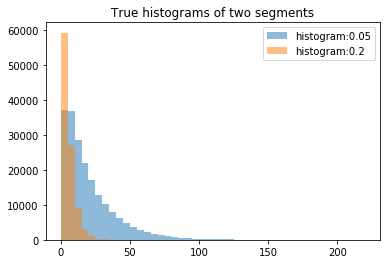

In [6]:
max_time_1and2 = np.max(time_1and2).astype(int)
bins_1and2 = range(0,max_time_1and2,5)

plt.hist(time_1,bins = bins_1and2,alpha = 0.5)
plt.hist(time_2,bins = bins_1and2,alpha = 0.5)
plt.title('True histograms of two segments')
plt.legend(['histogram:0.05','histogram:0.2'])

plt.show()

真の分布は上記の分布です。ただし今回はどちらの集団に属しているのかは観測できなため、以下のような分布で学習を行います。

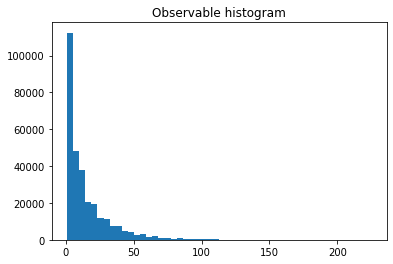

In [7]:
plt.hist(time_1and2,stacked = True,bins = 50)
plt.title('Observable histogram')
plt.show()

### 単純な指数分布で推定した場合

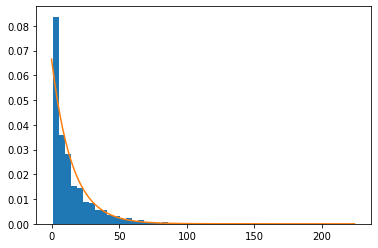

In [8]:
# パラメーターを最尤推定値で更新
Exp_object = ExpDistribution()
Exp_object.MLEfit(time_1and2)
x_dist = np.arange(np.max(time_1and2))

plt.hist(time_1and2,bins = 50,density = True)
plt.plot(Exp_object.PDF(x_dist))
plt.show()

この場合、うまく推定できていません。

### 混合指数モデルによる学習結果

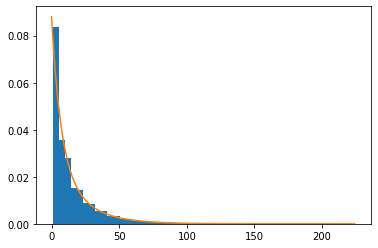

In [9]:
# オブジェクトを作る
np.random.seed(0)
EMM = ExpMixModel()

# パラメーターをEMアルゴリズムで更新
EMM.fit(time_1and2)
x_dist = np.arange(np.max(time_1and2))

plt.hist(time_1and2,bins = 50,density = True)
plt.plot(np.exp(EMM.log_pdf(x_dist)))
plt.show()

パラメーターの更新によってヒストグラムに当てはめることができました。

### 推定結果と真の集団との比較

アルゴリズムで推定された分布と、真の分布を比較します。

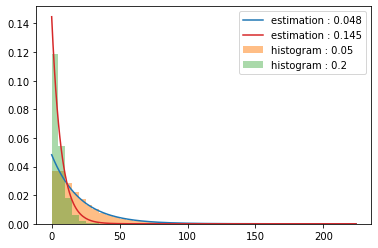

セグメント1： 0.048228218088447364
セグメント2： 0.14470321409773074


In [10]:
plt.plot(EMM.ExpDist_list[0].PDF(x_dist))
plt.hist(time_1,bins = bins_1and2,alpha = 0.5,density = True)

plt.hist(time_2,bins = bins_1and2,alpha = 0.4,density = True) #0.05
plt.plot(EMM.ExpDist_list[1].PDF(x_dist))


plt.legend(['estimation : 0.048', 'estimation : 0.145', 'histogram : 0.05', 'histogram : 0.2'])

plt.show()
for i in range(K):
    print('セグメント'+str(i + 1)+'：',
          EMM.ExpDist_list[i].param_la)

推定結果から、確率0.05でイベントを発生させる集団と、確率0.15でイベントを発生させる集団に分類できることがわかります。

シミュレーションデータと比較すると、0.05の集団は正しく推定できていますが、0.2の集団のほうは、0.15と推定しているため、少し精度が悪いです。

### 考察と今後の課題

　今回のアルゴリズムでは、クラスター数の特定について曖昧なため、パラメーターの評価について見直す必要があると考えました。またイベント発生時間以外のデータも用いて、潜在変数モデルを拡張したいと考えています。今回のデータでは、観測の打ち切りを考慮していないため、生存時間解析理論等を用いてさらにアルゴリズムを発展させたいとも考えています。

### 【参考文献】

【書籍】

Pattern Recognition and Machine Learning（Information Science and Statistics）
著者：Christopher M. Bishop
出版社：Springer

<br>

【サイト】

指数混合分布 (Mixture of Exponential Distributions) 推定のバースト検出への応用<br>
http://nktmemoja.github.io/jekyll/update/2017/03/19/time-series-analysis.html